Realizacja zadania w ramach przedmiotu Pracownia Problemowa Magisterska

In [28]:
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hrv
from utils import get_first_from_fragment, get_data, get_rr_interval_for_period

Make sure that data is available at users machine and store data into variables

In [29]:
get_data('afdb')
record_name = '../afdb/04043'

signal, properties = wfdb.rdsamp(record_name, channels=[1])
annotations = wfdb.rdann(record_name, 'atr')
QRS = wfdb.rdann(record_name, 'qrs')
Rhythm = pd.Series(annotations.aux_note)
Rpeak_Symbols = pd.Series(QRS.symbol)
Rpeak_Sample = pd.Series(QRS.sample)
AnnotationRhythm = pd.Series(annotations.aux_note)
AnnotationSymbols = pd.Series(pd.Series(annotations.symbol)).values
AnnotationSamples = pd.Series(pd.Series(annotations.sample)).values

f = properties["fs"]
T = 1 / f
samples_per_minutes = f * 60

You already have the data.


/Users/amelia/Projects/MGR/.venv/lib/python3.12/site-packages/wfdb/io/annotation.py:2240: RuntimeWarning: overflow encountered in scalar add
  sample_diff += int(filebytes[bpi, 0] + 255 * (filebytes[bpi, 1] & 3))


Preprocessing - combining data from qre and atr annotations to store data about class of each R peak.

In [30]:
labeled_Rpeaks = []
appended_data = []

for j in range(len(AnnotationSamples) - 1):
    df = pd.DataFrame(Rpeak_Sample[(Rpeak_Sample > AnnotationSamples[j]) & (Rpeak_Sample < AnnotationSamples[j + 1])])
    df['Label'] = AnnotationRhythm[j]
    appended_data.append(df)
labeled_Rpeaks = pd.concat(appended_data)

Rpeaks_classified = labeled_Rpeaks.loc[(labeled_Rpeaks.Label == '(N') | (labeled_Rpeaks.Label == '(AFIB'), :]
Rpeaks_classified.loc[:, 'Label'] = Rpeaks_classified['Label'].map({'(N': 0, '(AFIB': 1})
Rpeaks_classified.rename(columns={0: 'Rpeaks'}, inplace=True)

/var/folders/bv/ql_k1ckj0dn75hz1mgfs9xlh0000gn/T/ipykernel_8265/2667106583.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rpeaks_classified.rename(columns={0: 'Rpeaks'}, inplace=True)


Divide sample data into 60 seconds fragments - all r peaks for this period and calculate RR intervals for them. In this use case only one example, but it can be easily adjusted for needs of more active user. It uses function, but for demonstration purposes I've chosen perfect centered fragment that is why data is moved by 7000 samples 

In [31]:
negative_starts, positive_starts = get_first_from_fragment(Rpeaks_classified)
r_peaks = Rpeak_Sample.values

rr_intervals_negative = get_rr_interval_for_period(r_peaks, negative_starts, 0, f)
rr_intervals_positive = [(r_peaks[i + 1] - r_peaks[i]) * T * 1000 for i in
                         range(np.where(r_peaks > positive_starts[0] + 7000)[0][0],
                               (np.where(r_peaks < positive_starts[0] + 7000 + samples_per_minutes)[0][-1]))]

Calculate and display HRV parameters

In [32]:
print("Parameters for negative example:\n", hrv.get_parameters(rr_intervals_negative))
print("Parameters for positive example:\n", hrv.get_parameters(rr_intervals_positive))

Parameters for negative example:
 {'mean_rr': 559.25, 'sdrr': 8.34, 'sdsd': 13.04, 'rmssd': 12.98, 'median_rr': 560.0, 'range_rr': 40.0, 'cvsd': 0.02, 'cvrr': 0.01, 'mean_hr': 107.31, 'max_hr': 110.29, 'min_hr': 102.74, 'std_hr': 1.59}
Parameters for positive example:
 {'mean_rr': 479.97, 'sdrr': 111.35, 'sdsd': 136.69, 'rmssd': 136.14, 'median_rr': 442.0, 'range_rr': 560.0, 'cvsd': 0.31, 'cvrr': 0.25, 'mean_hr': 131.03, 'max_hr': 176.47, 'min_hr': 66.67, 'std_hr': 26.82}


Plot the fragment of ECG with negative example and positive one wih visible AF

/var/folders/bv/ql_k1ckj0dn75hz1mgfs9xlh0000gn/T/ipykernel_8265/356214715.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


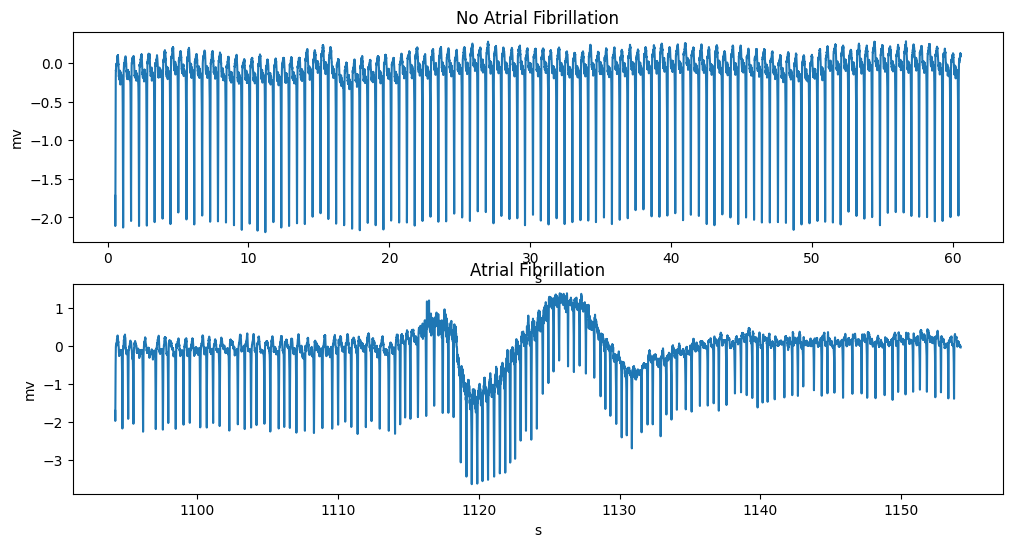

In [33]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 6))
ecg = signal[:, 0]
ax[0].plot(list(
    np.arange(negative_starts[0] * T, (negative_starts[0] + samples_per_minutes) * T, T)),
    ecg[negative_starts[0]: (negative_starts[0] + samples_per_minutes + 1)])
ax[1].plot(list(
    np.arange((positive_starts[0] + 7000) * T, (positive_starts[0] + samples_per_minutes + 7000) * T, T)),
    ecg[(positive_starts[0] + 7000): (positive_starts[0] + samples_per_minutes + 7000)])
ax[0].set_title('No Atrial Fibrillation')
ax[0].set_ylabel('mv')
ax[0].set_xlabel('s')
ax[1].set_title('Atrial Fibrillation')
ax[1].set_ylabel('mv')
ax[1].set_xlabel('s')
fig.show()

For the future:
- get all files at once and manage them together
- manage both channels
- train prebuild model
- (?) use own PanTopkins